# **Experiment 7 | EC69210**
**Code Authors:** Irsh Vijay (21EC39055) and Aditya Raj (21EC39001) \

Using device: cuda
Training samples: 1500
Testing samples: 250
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch 1 | Loss: 2.9079806804656982 | Acc: 18.75%
Batch 11 | Loss: 2.189790964126587 | Acc: 50.00%
Batch 21 | Loss: 1.7949647903442383 | Acc: 68.75%
Batch 31 | Loss: 1.6593588590621948 | Acc: 56.25%
Batch 41 | Loss: 1.6394188404083252 | Acc: 75.00%
Batch 51 | Loss: 1.8096747398376465 | Acc: 56.25%
Batch 61 | Loss: 1.8506715297698975 | Acc: 50.00%
Batch 71 | Loss: 1.7142019271850586 | Acc: 62.50%
Batch 81 | Loss: 1.9726903438568115 | Acc: 50.00%
Batch 91 | Loss: 1.8095437288284302 | Acc: 37.50%
Train Loss: 1.7786, Train Acc: 0.6273
Val Loss: 1.4118, Val Acc: 0.7960
Saved best model!
Epoch 2/10
Batch 1 | Loss: 1.3693904876708984 | Acc: 81.25%
Batch 11 | Loss: 1.5398262739181519 | Acc: 68.75%
Batch 21 | Loss: 1.5300425291061401 | Acc: 75.00%
Batch 31 | Loss: 1.4543837308883667 | Acc: 75.00%
Batch 41 | Loss: 1.611911654472351 | Acc: 62.50%
Batch 51 | Loss: 1.3743178844451904 | Acc: 81.25%
Batch 61 | Loss: 1.9328935146331787 | Acc: 68.75%
Batch 71 | Loss: 1.4398514032363892 | Acc: 68.75%
Bat

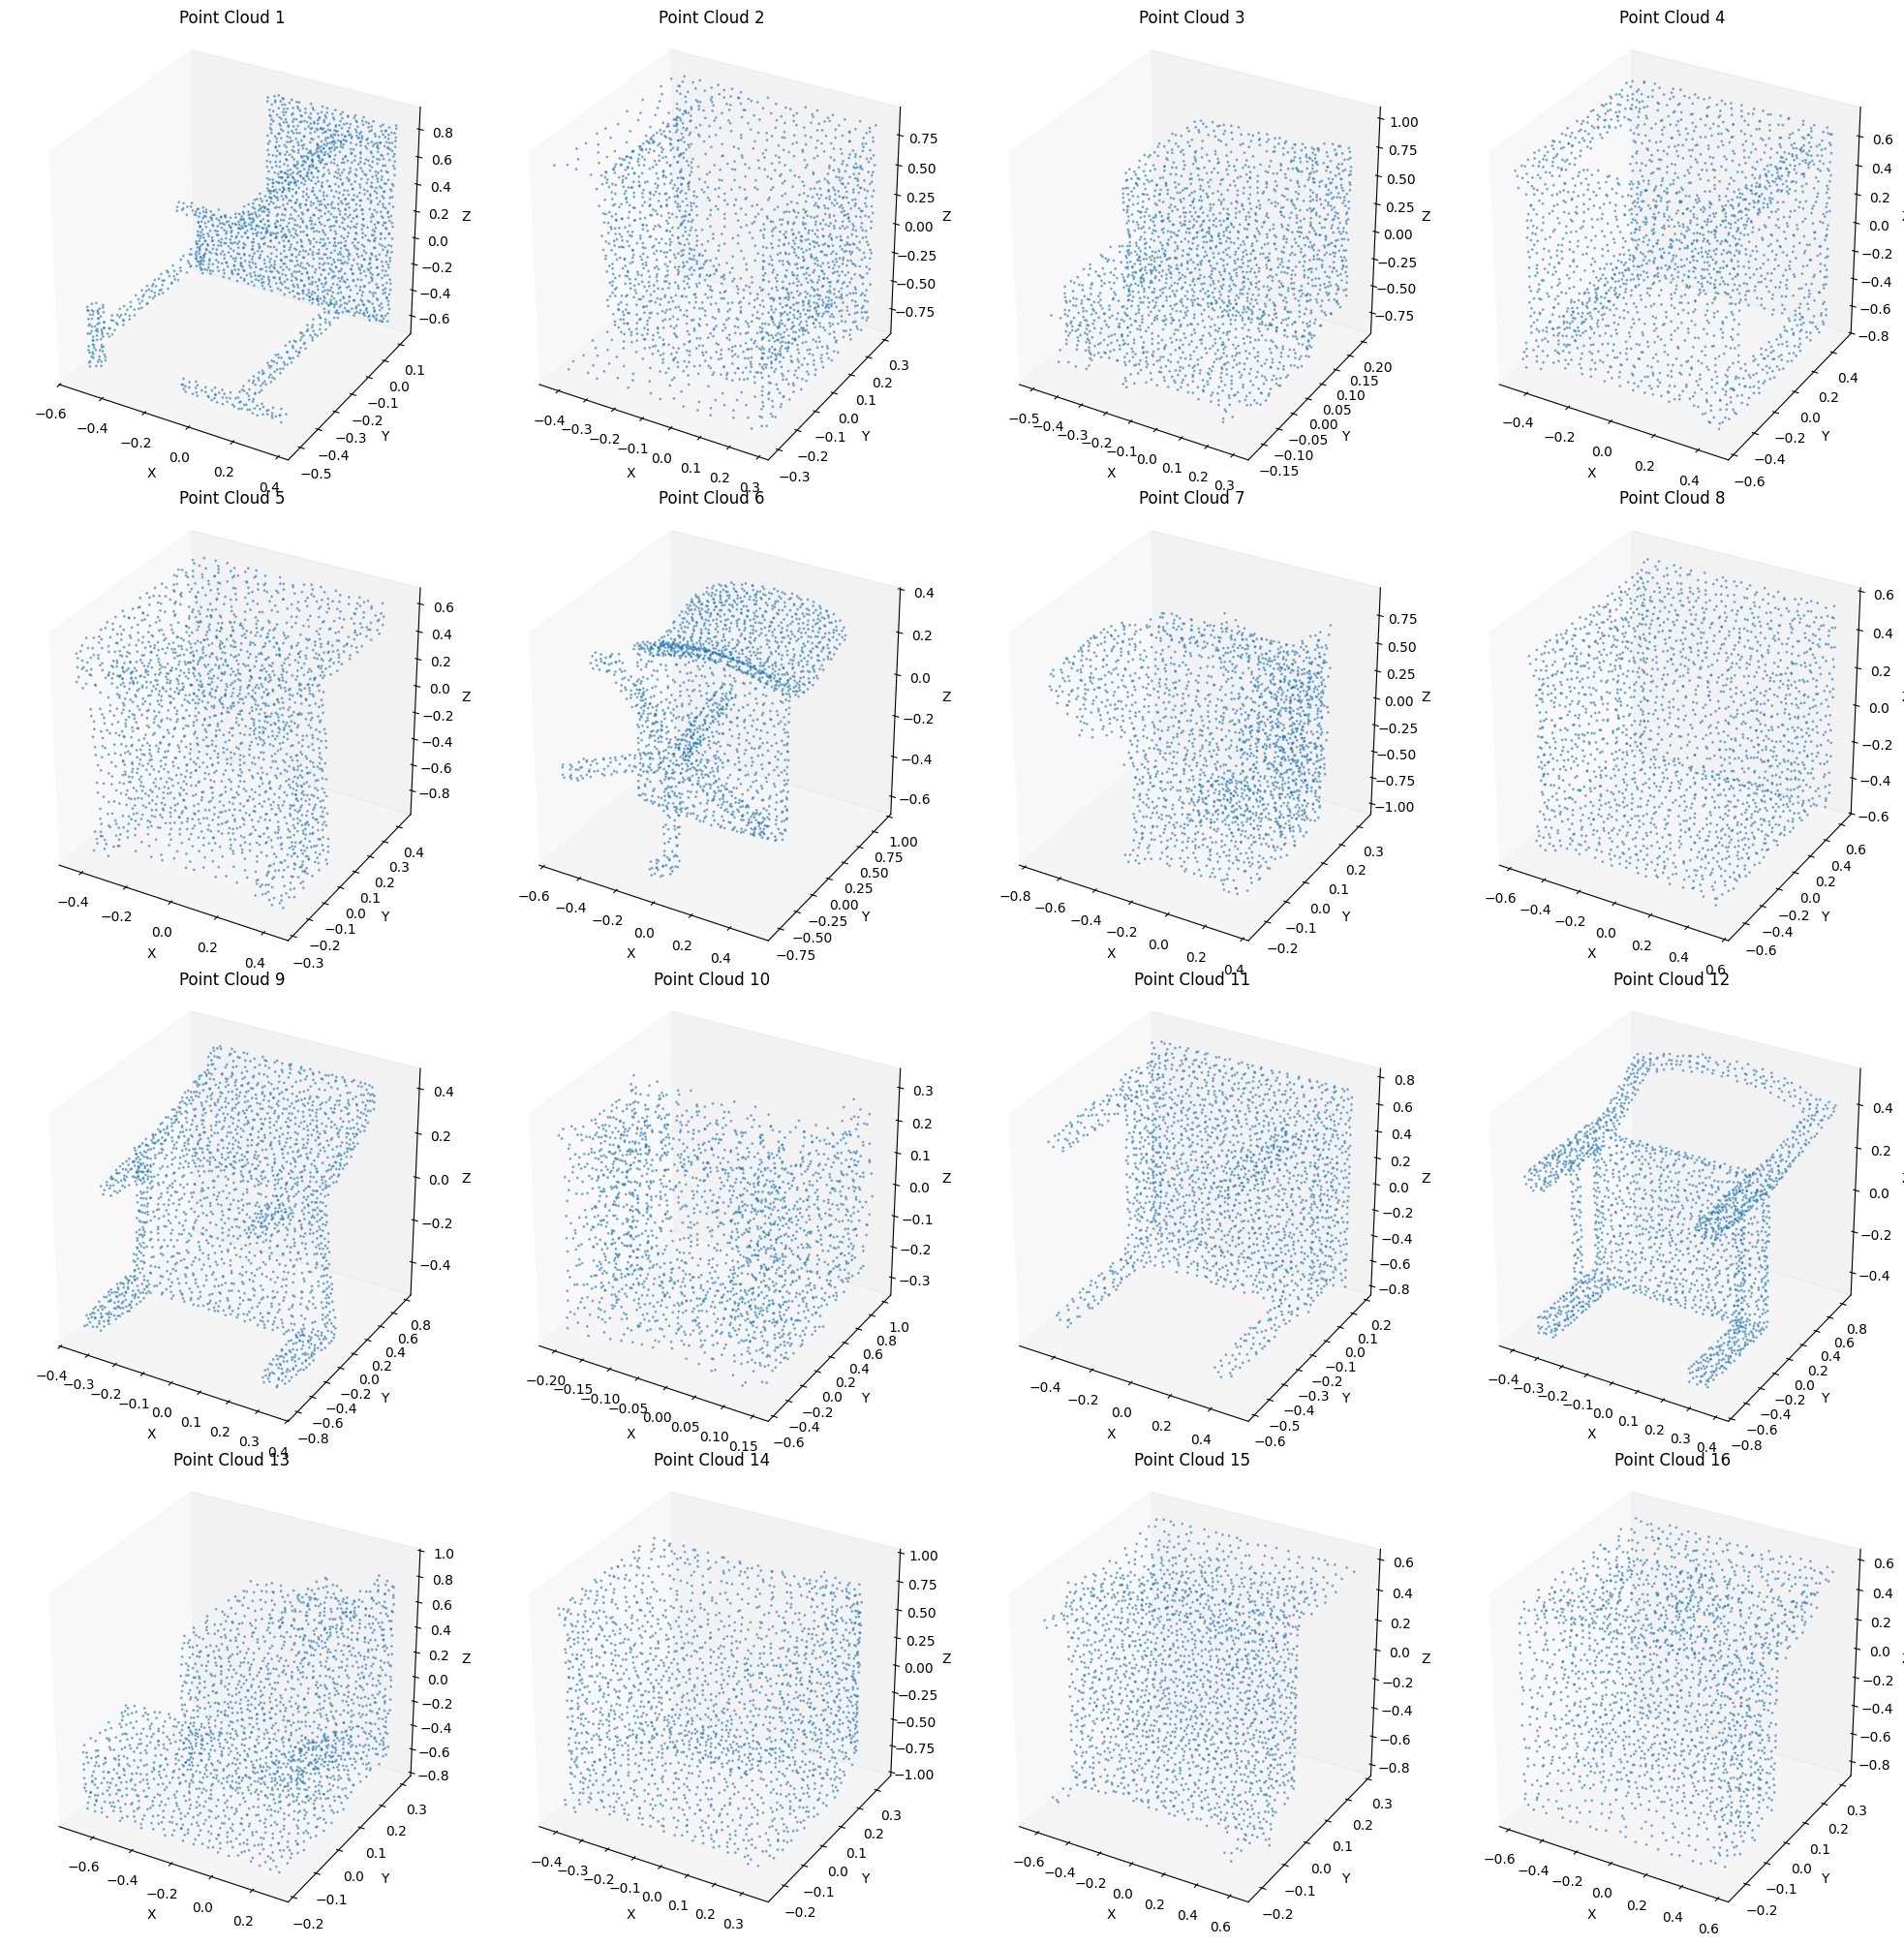

In [ ]:
# Complete the tasks mentioned as "TODO: Task:<>"
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# TODO:Task 1: Import necessary libraries:

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# visualize point clouds for a batch
def visualize_point_cloud(batch, fig_size=(20, 20)):
    if torch.is_tensor(batch):
        batch = batch.numpy()

    fig = plt.figure(figsize=fig_size)
    for i in range(16):
        point_cloud = batch[i]
        row = i // 4
        col = i % 4
        # Create 3D subplot
        ax = fig.add_subplot(4, 4, i+1, projection='3d')

        # Extract x, y, z coordinates
        x = point_cloud[:, 0]
        y = point_cloud[:, 1]
        z = point_cloud[:, 2]
        # Plot 3D scatter
        ax.scatter(x, y, z, s=1, alpha=0.5)

        ax.set_title(f'Point Cloud {i+1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_box_aspect([1, 1, 1])
        ax.grid(False)

    plt.tight_layout()
    plt.savefig('visualize.jpg', format='jpg',bbox_inches='tight')

# Point Cloud Transforms
class RandomRotation(object):
    def __call__(self, points):
        # Random rotation around z-axis
        theta = np.random.uniform(0, 2*np.pi)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1]
        ])
        return np.dot(points, rotation_matrix)

class RandomJitter(object):
    def __init__(self, sigma=0.01, clip=0.05):
        self.sigma = sigma
        self.clip = clip

    def __call__(self, points):
        jitter = np.clip(np.random.normal(0, self.sigma, points.shape), -self.clip, self.clip)
        return points + jitter

class ToTensor(object):
    def __call__(self, points):
        return torch.from_numpy(points).float()


# ModelNet10 Dataset
# TODO:Task 2: Define ModelNet10 dataset:
class ModelNet10(Dataset):
    def __init__(self, data_path, phase='train', num_points=2048, transforms=None):
        self.paths = (f"{data_path}/points_{phase}.npy", f"{data_path}/labels_{phase}.npy")
        self.points = np.load(self.paths[0])
        self.labels = np.load(self.paths[1])
        self.transforms = transforms
        self.points = self.transforms(self.points) if self.transforms is not None else self.points
        # print(self.points.shape)
        self.points = self.points.permute((0, 2, 1))

    def __getitem__(self, idx):
        return self.points[idx], self.labels[idx]

    def __len__(self):
        return len(self.points)

# ds1 = ModelNet10("./")
# visualize_point_cloud([ds1[i][0] for i in range(16)], )
# assert ds1[0][0].shape==(3, 2048), ds1[0][0].shape
# del ds1

# TODO:Task 3: Define PointNetClassifier model
class PointNetClassifier(nn.Module):
    def __init__(self, num_channel=3, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv1d(num_channel, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, num_classes)

        self.drop1 = nn.Dropout(p=0.3)
        self.drop2 = nn.Dropout(p=0.3)

    # hint: NLL loss takes log-softmax as input
    # Use F.log_softmax across proper dimension as the final output
    # use torch max along proper dimension for maxpool
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        x, _ = torch.max(x, axis=2)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.bn4(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.bn5(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=0)
        return x





inp = torch.randn((16, 3, 2048))
model = PointNetClassifier()
op = model(inp)
assert op.shape == (16, 10)
del model, inp, op



# TODO:Task 4:Training function
# hint:check dimension of inputs and labels while calculating loss
# use torch.transpose() and torch.squeeze() if needed
# function should return train loss and train accuracy
# print training loss after each batch for sanity check
def calc_accuracy(outputs, labels):
    outputs = torch.argmax(outputs, axis=1)
    correct = 0
    for op, lab in zip(outputs, labels):
        if op.item() == lab.item():
            correct += 1

    return correct, outputs.shape[0]

def train(model, train_loader, optimizer, criterion, device='cpu'):
    model = model.to(device)
    model.train()
    losses = []
    num_correct = 0
    num_total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        correct, total = calc_accuracy(outputs, labels)
        num_correct += correct
        num_total += total
        if i%10 == 0:
          print(f"Batch {i+1} | Loss: {loss.item()} | Acc: {correct/total:.2%}")
        losses.append(loss.item())

    return np.mean(losses), num_correct / num_total


# TODO:Task 5: Evaluation function
# hint:check dimension of inputs and labels while calculating loss
# use torch.transpose() and torch.squeeze() if needed
# function should return test loss and test accuracy
def evaluate(model, val_loader, criterion, device):
    model = model.to(device)
    model.eval()
    losses = []
    num_correct = 0
    num_total = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        correct, total = calc_accuracy(outputs, labels)
        num_correct += correct
        num_total += total

        losses.append(loss.item())

    return np.mean(losses), num_correct / num_total




def main():
    # TODO: Task 6: Initialize necessary components
    # 'Path to ModelNet10 dataset'
    data_path = "./"
    # 'Number of training epochs'
    epochs = 10
    # 'Learning rate'
    lr = 1e-3

    # 'Batch size'
    batch_size = 16
    # 'Number of points in each point cloud'
    num_points = 2048
    # 'Random seed'
    seed = 42

    set_seed(seed)

    # Force CPU usage
    device = torch.device("cuda")
    print(f"Using device: {device}")

    # Data transforms
    # TODO:Task 7: Complete train_transform and test transform code:
    # train transform: Random rotation, jitter and convert to tensor
    # test trasnfrom = convert to tensor
    train_transform = transforms.Compose([
            RandomRotation(),
            RandomJitter(),
            ToTensor(),
        ])


    test_transform = transforms.Compose([
            ToTensor()
        ])


    # TODO:Task 8 Load dataset and dataloader :
    train_dataset = ModelNet10(data_path, phase='train', transforms=train_transform)

    test_dataset = ModelNet10(data_path, phase='test', transforms=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    #if you keep batch size other than 16, comment out visualize_point_cloud part
    for batch, _ in train_loader:
        batch = batch.permute((0, 2, 1))
        visualize_point_cloud(batch)
        break

    # Initialize model
    model = PointNetClassifier().to(device)
    criterion = nn.NLLLoss()

    # TODO:Task 9 optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


    # Training loop
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model!")

    print(f"Best validation accuracy: {best_acc:.4f}")

    # TODO:Task 10 Congrats, no more tasks

if __name__ == "__main__":
    main()
